# Classification model with convolutional neural network
*   The purpose of this notebook is to practice building an image classification systen. A range of data preprocessing and augmentation has been conducted.
*   Although I have experimented with various CNN models and data preprocessing techniques, the best model and data preprocessing technique have been chosen in this notebook.
*   The performance of the system has been improved through data preprocessing rather than the machine learning model.
*   The dataset in this system is a collection of images of retinas that are potentially developing diabetic retinopathy. This dataset is provided by APTOS 2019 Blindness Detection of [Kaggle](https://www.kaggle.com/competitions/aptos2019-blindness-detection/) competition.
*   The number of images: 3662 (Train), 1927 (Test)
*   Best score by other competitors: 93.6129%

In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
import os

from tqdm.notebook import tqdm
from collections import OrderedDict
import glob
import cv2
import random
import time, datetime
import copy

from torchvision.io import read_image
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data.dataset import Subset

import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

# Fix random seed

In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
#     # Numpy
#     np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
#     # Tensorflow
#     tf.random.set_seed(seed)

SEED = 3407
fix_seed(SEED)

# Load dataset

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Note that code for importing kaggle dataset is commented out.

In [4]:
# import json

# f = open("/content/drive/MyDrive/kaggle.json", 'r')
# json_data = json.load(f)

# os.environ['KAGGLE_USERNAME'] = json_data['username']
# os.environ['KAGGLE_KEY'] = json_data['key']

In [5]:
# !pip install kaggle

In [6]:
# !kaggle competitions download -c aptos2019-blindness-detection

In [7]:
# !unzip '/content/aptos2019-blindness-detection.zip'

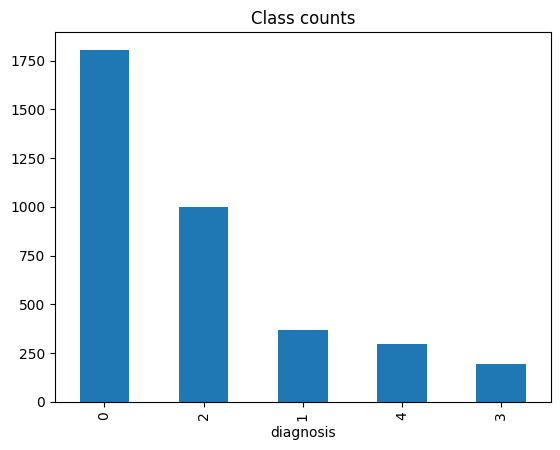

In [8]:
# Train data
# train_target = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
train_target = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')

train_target['diagnosis'].value_counts().plot(kind='bar');
plt.title('Class counts');

In [9]:
paths = glob.glob(r'/kaggle/input/aptos2019-blindness-detection/train_images/*.png')
heights, widths = zip(*[cv2.imread(path).shape[:2] for path in tqdm(paths)])

  0%|          | 0/3662 [00:00<?, ?it/s]

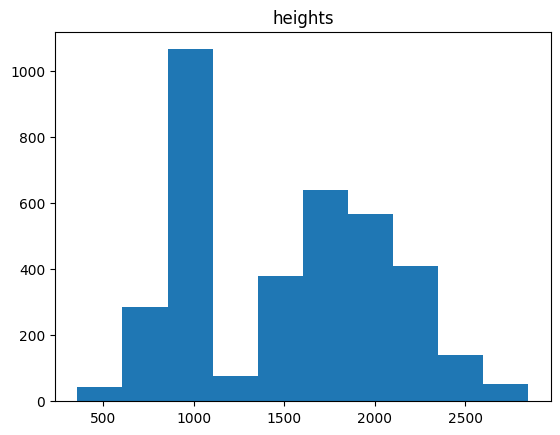

In [10]:
plt.hist(heights, bins = 10)
plt.title('heights')
plt.show()

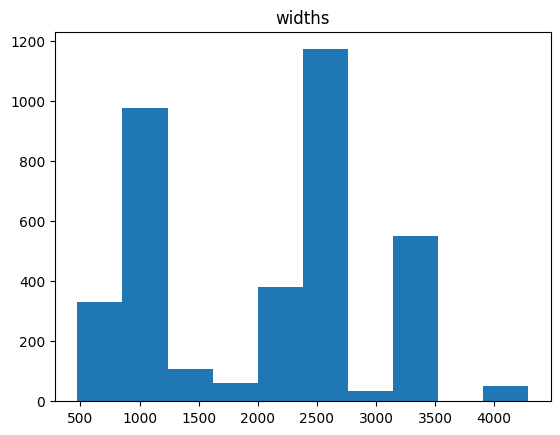

In [11]:
plt.hist(widths, bins = 10)
plt.title('widths')
plt.show()

# Define dataset and dataloader

In [12]:
# Define dataset class

class CustomImageDataset(Dataset):
    def __init__(self, img_labels: pd.DataFrame, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_labels = img_labels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + ".png")
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, idx

In [13]:
resize_h = 224
resize_w = 224
input_shape = (resize_h, resize_w)

pre_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize(input_shape)
])

tensor_aptos = CustomImageDataset(train_target, "/kaggle/input/aptos2019-blindness-detection/train_images", pre_transforms)

In [14]:
imgs = torch.stack([img_t for img_t, _, _ in tqdm(tensor_aptos)], dim=3)
imgs.shape

  0%|          | 0/3662 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 224, 224, 3662])

In [15]:
mean = imgs.view(3, -1).mean(dim=1)
print(mean)

tensor([0.4138, 0.2210, 0.0737])


In [16]:
std = imgs.view(3, -1).std(dim=1)
print(std)

tensor([0.2745, 0.1499, 0.0808])


In [17]:
augment_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=180)
])

preprocess_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize(input_shape),
    transforms.Normalize(mean, std)
])

# train_img_path = "/kaggle/input/aptos2019-blindness-detection/train_images"
train_img_path = "/kaggle/input/aptos2019-blindness-detection/train_images"

trainval_data = CustomImageDataset(train_target, train_img_path, preprocess_transforms)

val_size = round(len(trainval_data) * 0.2)
train_size = len(trainval_data) - val_size
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size], generator=torch.manual_seed(3407))

The code commented out below is to mitigate the imbalanced dataset with oversampling.

In [18]:
# # sampler to balance the amount of samples in dataset
# labels = train_target['diagnosis'].values
# class_counts = torch.bincount(torch.tensor(labels))
# weights = 1. / class_counts.float()
# sample_weights = weights[labels]
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [19]:
labels_map = {
    0: "No",
    1: "Mi",
    2: "Mo",
    3: "Se",
    4: "Pr"
}

In [20]:
def display_images(dataset):
    figure = plt.figure(figsize=(10, 10))
    cols, rows = 10, 10
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label, _ = trainval_data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze().permute(1,2,0))
    plt.show()

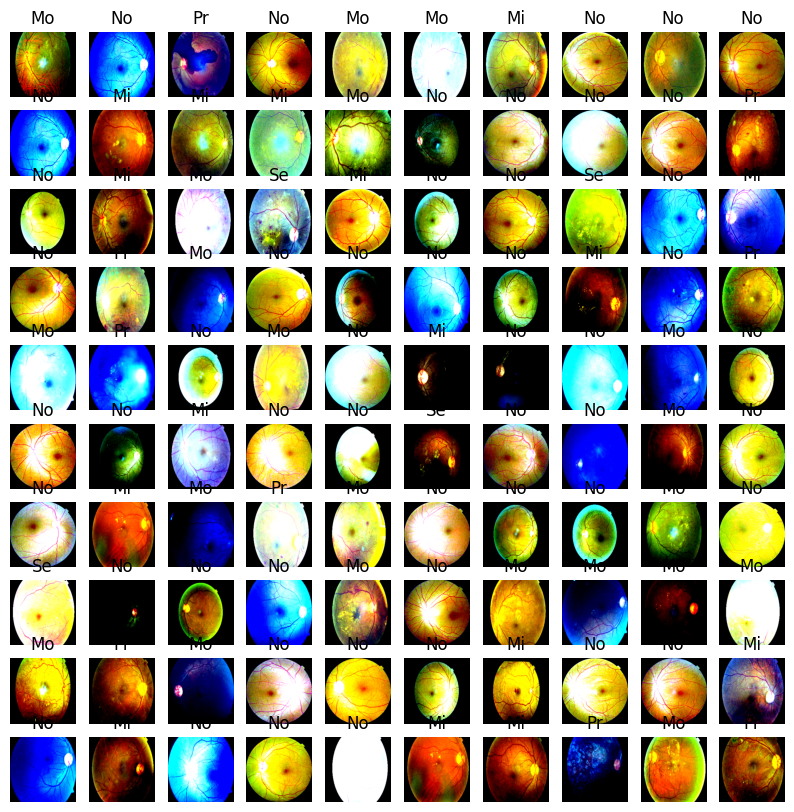

In [21]:
# TrainVal images
display_images(trainval_data)

In [22]:
# Define dataloader

batch_size = 64

method = "None"

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    # sampler=sampler
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

# dataloader_trainval = torch.utils.data.DataLoader(
#     trainval_data,
#     batch_size=batch_size,
#     # sampler=sampler
#     shuffle=True
# )

dataloaders_dict = {'Train': dataloader_train, 'Validation': dataloader_valid}
# dataloader_fine_tune = {'Train': dataloader_train}
# dataloader_dict = {'TrainVal': dataloader_trainval}

# Define CNN model

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

The code commented out below is a method that mitigate the imbalanced dataset cost-sensitive learning.

In [24]:
# def weight_loss(weight, cost_sensitive=False):
#     loss = None
#     if cost_sensitive:
#         loss = nn.CrossEntropyLoss(weight=weight, reduction='mean')
#     else:
#         loss = nn.CrossEntropyLoss()
#     return loss, cost_sensitive

In [25]:
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_target['diagnosis'].values), y=train_target['diagnosis'].values)
# class_weights=torch.tensor(class_weights,dtype=torch.float)

In [26]:
model = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.DEFAULT)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 5)

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0001)
# criterion, cost_sensitive = weight_loss(class_weights, cost_sensitive=False) # according to an article
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=32, eta_min=1e-4)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 102MB/s]


# Define train model

In [27]:
# Code from https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [28]:
def train_model(model, device, dataloaders: dict, criterion, optimizer, scheduler=None, num_epochs=25, is_inception=False, augumented=False):
    since = time.time()

    model = model.to(device)
    criterion = criterion.to(device)

    histories = {'Accuracy': {phase: list() for phase in dataloaders.keys()}, 'Loss': {phase: list() for phase in dataloaders.keys()}, 'Kappa': {phase: list() for phase in dataloaders.keys()}}
    f1_macro = list()
    classification_reports = list()

    
    best_score = 0

    early_stopping = EarlyStopping(patience=5, verbose=True)

    class0, class1, class2, class3, class4, = 0, 0, 0, 0, 0

    for epoch in range(num_epochs):
        print('EPOCH: {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in dataloaders.keys():
            if phase == 'Validation':
                model.eval()   # Set model to evaluate mode
            else:
                model.train()  # Set model to training mode

            losses = []
            num = 0
            true_num = 0

            y_preds = []
            y_trues = []

            # Iterate over data.
            for x, t, idx in tqdm(dataloaders[phase]):
                model.zero_grad()  # Initialise gradient descent
                if (phase == 'Train' or phase == 'TrainVal') and augumented:
                    x = augment_transforms(x)
                x, t = x.to(device), t.to(device)

                # zero the parameter gradients
                # optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train' or phase == 'TrainVal'):
                    y = model(x)  # Forward propagation
                    loss = criterion(y, t)

                    pred = y.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if (phase == 'Train' or phase == 'TrainVal'):
                        loss.backward()
                        optimizer.step()
                        
                    y_preds += pred.to("cpu").tolist()
                    y_trues += t.to("cpu").tolist()

                    losses.append(loss.tolist())

                    acc = torch.where(t.to("cpu") - pred.to("cpu") == 0, torch.ones_like(t).to("cpu"), torch.zeros_like(t).to("cpu"))
                    num += acc.size()[0]
                    true_num += acc.sum().item()

            epoch_loss = np.mean(losses)
            epoch_acc = true_num / num
            epoch_kappa = cohen_kappa_score(y_preds, y_trues)

            histories['Loss'][phase].append(epoch_loss)
            histories['Accuracy'][phase].append(epoch_acc)
            histories['Kappa'][phase].append(epoch_kappa)


            print('{} [Loss: {:.4f}, Accuracy: {:.4f}, Kappa: {:.4f}]'.format(phase, epoch_loss, epoch_acc, epoch_kappa))
            print()
            scheduler.step()
            
            if (phase == 'Validation'):
                early_stopping(np.mean(epoch_loss), model)
                best_score = early_stopping.best_score
        if early_stopping.early_stop:
            num_epochs = epoch + 1
            break

        print()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model, num_epochs, histories, augumented, best_score, time_elapsed, f1_macro, classification_reports

In [29]:
def plot(n_epochs, histories: dict):
    epochs = np.arange(1, n_epochs + 1)

    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 3))

    for ax, metric in zip([ax1, ax2, ax3], histories.keys()):
        ax.set_title(metric)
        for key in histories[metric].keys():
            ax.plot(epochs, histories[metric][key], label=key)
        ax.set_xlabel("Epoch")
        ax.legend()

    plt.show()

# Train the model

In [30]:
model, num_epochs, histories, augumented, best_score, time_elapsed, f1_macro, classification_reports = train_model(model, device, dataloaders_dict, criterion, optimizer, scheduler, num_epochs=25, is_inception=False, augumented=True)

EPOCH: 1/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

Train [Loss: 1.0329, Accuracy: 0.6297, Kappa: 0.3937]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.7739, Accuracy: 0.7022, Kappa: 0.4980]

Validation loss decreased (inf --> 0.773942).  Saving model ...


EPOCH: 2/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.6885, Accuracy: 0.7440, Kappa: 0.5872]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.6310, Accuracy: 0.7514, Kappa: 0.5977]

Validation loss decreased (0.773942 --> 0.631002).  Saving model ...


EPOCH: 3/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.5904, Accuracy: 0.7754, Kappa: 0.6425]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.5786, Accuracy: 0.7842, Kappa: 0.6601]

Validation loss decreased (0.631002 --> 0.578647).  Saving model ...


EPOCH: 4/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.5563, Accuracy: 0.7836, Kappa: 0.6596]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.5642, Accuracy: 0.7828, Kappa: 0.6588]

Validation loss decreased (0.578647 --> 0.564162).  Saving model ...


EPOCH: 5/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.5225, Accuracy: 0.8038, Kappa: 0.6951]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.5275, Accuracy: 0.7992, Kappa: 0.6848]

Validation loss decreased (0.564162 --> 0.527453).  Saving model ...


EPOCH: 6/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.4832, Accuracy: 0.8198, Kappa: 0.7210]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.5087, Accuracy: 0.8060, Kappa: 0.6947]

Validation loss decreased (0.527453 --> 0.508737).  Saving model ...


EPOCH: 7/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.4675, Accuracy: 0.8242, Kappa: 0.7282]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4917, Accuracy: 0.8169, Kappa: 0.7150]

Validation loss decreased (0.508737 --> 0.491715).  Saving model ...


EPOCH: 8/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.4436, Accuracy: 0.8355, Kappa: 0.7461]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4795, Accuracy: 0.8265, Kappa: 0.7301]

Validation loss decreased (0.491715 --> 0.479492).  Saving model ...


EPOCH: 9/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.4540, Accuracy: 0.8276, Kappa: 0.7346]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4812, Accuracy: 0.8292, Kappa: 0.7343]

EarlyStopping counter: 1 out of 5


EPOCH: 10/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.4100, Accuracy: 0.8461, Kappa: 0.7631]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4681, Accuracy: 0.8251, Kappa: 0.7293]

Validation loss decreased (0.479492 --> 0.468131).  Saving model ...


EPOCH: 11/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.4241, Accuracy: 0.8440, Kappa: 0.7594]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4535, Accuracy: 0.8306, Kappa: 0.7382]

Validation loss decreased (0.468131 --> 0.453518).  Saving model ...


EPOCH: 12/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.4064, Accuracy: 0.8536, Kappa: 0.7751]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4889, Accuracy: 0.8251, Kappa: 0.7276]

EarlyStopping counter: 1 out of 5


EPOCH: 13/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.4025, Accuracy: 0.8549, Kappa: 0.7763]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4491, Accuracy: 0.8388, Kappa: 0.7518]

Validation loss decreased (0.453518 --> 0.449088).  Saving model ...


EPOCH: 14/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.4045, Accuracy: 0.8478, Kappa: 0.7661]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4633, Accuracy: 0.8333, Kappa: 0.7414]

EarlyStopping counter: 1 out of 5


EPOCH: 15/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.3920, Accuracy: 0.8539, Kappa: 0.7757]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4572, Accuracy: 0.8347, Kappa: 0.7454]

EarlyStopping counter: 2 out of 5


EPOCH: 16/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.3900, Accuracy: 0.8519, Kappa: 0.7716]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4627, Accuracy: 0.8361, Kappa: 0.7456]

EarlyStopping counter: 3 out of 5


EPOCH: 17/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.3933, Accuracy: 0.8543, Kappa: 0.7764]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4449, Accuracy: 0.8374, Kappa: 0.7493]

Validation loss decreased (0.449088 --> 0.444852).  Saving model ...


EPOCH: 18/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.3932, Accuracy: 0.8543, Kappa: 0.7757]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4711, Accuracy: 0.8347, Kappa: 0.7441]

EarlyStopping counter: 1 out of 5


EPOCH: 19/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.3964, Accuracy: 0.8529, Kappa: 0.7741]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4655, Accuracy: 0.8347, Kappa: 0.7448]

EarlyStopping counter: 2 out of 5


EPOCH: 20/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.3953, Accuracy: 0.8546, Kappa: 0.7766]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4580, Accuracy: 0.8292, Kappa: 0.7351]

EarlyStopping counter: 3 out of 5


EPOCH: 21/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.3965, Accuracy: 0.8532, Kappa: 0.7748]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4589, Accuracy: 0.8279, Kappa: 0.7330]

EarlyStopping counter: 4 out of 5


EPOCH: 22/25
----------


  0%|          | 0/46 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train [Loss: 0.3826, Accuracy: 0.8584, Kappa: 0.7820]



  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation [Loss: 0.4858, Accuracy: 0.8306, Kappa: 0.7369]

EarlyStopping counter: 5 out of 5
Training complete in 151m 2s


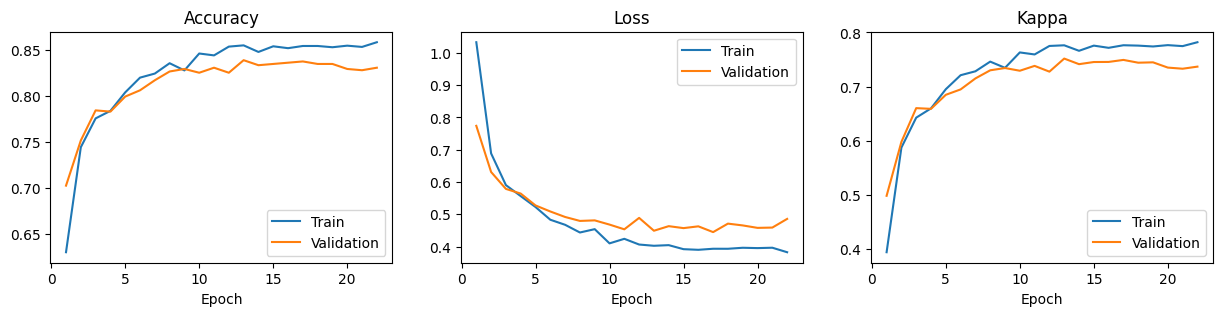

In [31]:
plot(num_epochs, histories)

In [32]:
torch.save(model, "densenet121-augmented.pth") # save the entire model with weight parameters, trained with train data

# Model performance on test set
The table below is showing the performance of this system as well as the performance of other systems. They are scored based on the quadratic weighted kappa, which measures the agreement between two ratings. Note that the APTOS 2019 Blindness Detection competition allows submission of the test result only via its website.
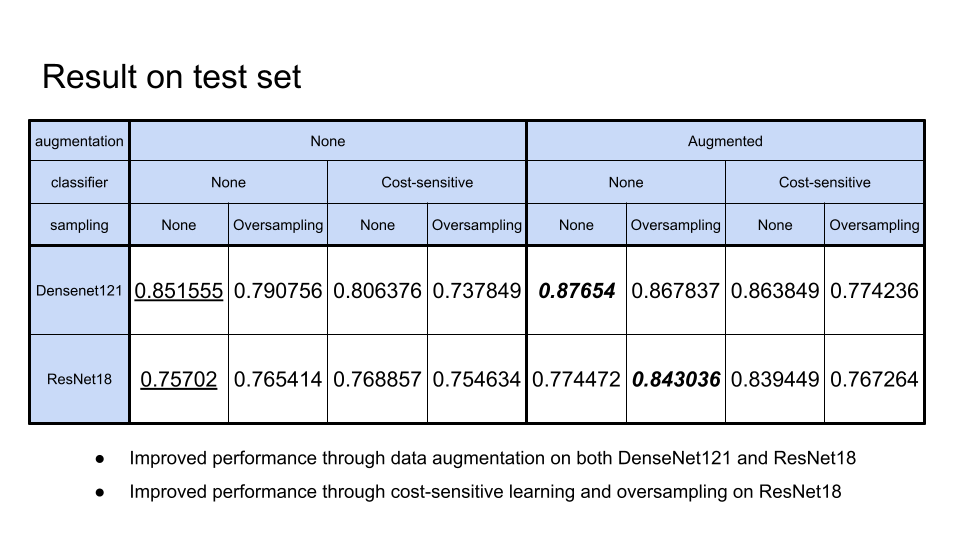